In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("poster")

%matplotlib inline

In [2]:
colnames = ["chr", "start", "end", "period", "unit"]
df_strs = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides.bed", sep="\t", header=None, names=colnames)
    .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"])])
)
df_strs

,chr,start,end,period,unit,str_id
0,chr1,14069,14081,4,CCTC,chr1_14069
1,chr1,16619,16631,3,GCT,chr1_16619
2,chr1,22811,22821,5,AGGAA,chr1_22811
3,chr1,26453,26465,2,GT,chr1_26453
4,chr1,28588,28603,1,T,chr1_28588
...,...,...,...,...,...,...
1733641,chrY,57188867,57188878,1,A,chrY_57188867
1733642,chrY,57200837,57200851,1,A,chrY_57200837
1733643,chrY,57200999,57201019,1,A,chrY_57200999
1733644,chrY,57202380,57202403,1,A,chrY_57202380


In [3]:
df_LMO = pd.read_csv("../../data/CRC/variants/CRC0282LMO-0-B_constrain.csv.gz")
df_01_0 = pd.read_csv("../../data/CRC/variants/CRC0282-01-0_constrain.csv.gz")

sample_dict = {
    "df_LMO": df_LMO, 
    "df_01_0": df_01_0, 
}

In [4]:
# sample: (lower, upper)
filter_bounds = {
    "df_LMO": (5.5, 26.5), 
    "df_01_0": (2+(8/9), 13+(1/3)),
}

def depth_norm_filter(df, bounds):
    return df.query(f"depth_norm >= {bounds[0]} and depth_norm <= {bounds[1]}").reset_index(drop=True)

In [5]:
df_LMO_filt = depth_norm_filter(df_LMO, filter_bounds["df_LMO"]).dropna().reset_index(drop=True)
df_LMO_filt["copy_number"] = df_LMO_filt["copy_number"].astype(np.int64)
print("LMO:", df_LMO.shape[0], df_LMO_filt.shape[0])

df_01_0_filt = depth_norm_filter(df_01_0, filter_bounds["df_01_0"]).dropna().reset_index(drop=True)
df_01_0_filt["copy_number"] = df_01_0_filt["copy_number"].astype(np.int64)
print("01_0:", df_01_0.shape[0], df_01_0_filt.shape[0])

LMO: 1733646 1620915
01_0: 1733646 1611859


## Simulate WGD event for LMO

In [68]:
def simulate_wgd(genotypes: pd.Series) -> pd.Series:
    wgd = []
    for i in genotypes:
        wgd.append(list(np.repeat(eval(i), 2)))
    return pd.Series(wgd)

In [69]:
wgd = simulate_wgd(df_LMO_filt["genotype"])
df_LMO_filt["genotype_wgd"] = wgd
df_LMO_filt = df_LMO_filt.assign(cn_wgd = lambda x: x["copy_number"] * 2)
df_LMO_filt.head()

,str_id,copy_number,frequencies,genotype,depth,depth_norm,genotype_wgd,cn_wgd
0,chr1_22811,2,{2: 28},"[2, 2]",28,14.0,"[2, 2, 2, 2]",4
1,chr1_26453,2,{6: 44},"[6, 6]",44,22.0,"[6, 6, 6, 6]",4
2,chr1_28588,2,"{10: 1, 15: 10, 16: 4, 17: 1}","[15, 16]",16,8.0,"[15, 15, 16, 16]",4
3,chr1_31555,2,{3: 23},"[3, 3]",23,11.5,"[3, 3, 3, 3]",4
4,chr1_31719,2,"{9: 1, 10: 15, 11: 3, 12: 9, 14: 1}","[10, 12]",29,14.5,"[10, 10, 12, 12]",4


In [95]:
df_comp = (df_LMO_filt
             .merge(df_01_0_filt,
                    left_on=["str_id", "cn_wgd"],
                    right_on=["str_id", "copy_number"],
                    suffixes=("_LMO", "_01_0"),
                    how="inner")
             .drop(["genotype_LMO", "copy_number_LMO"], axis=1)
             .merge(df_strs[["str_id", "period", "unit"]], on="str_id")
             .rename(columns={"cn_wgd": "copy_number_LMO", "genotype_wgd": "genotype_LMO"}))
df_comp = df_comp.assign(genotype_01_0 = lambda x: [eval(i) for i in x["genotype_01_0"]])
print(df_LMO_filt.shape, df_01_0_filt.shape)
print(df_comp.shape)
df_comp.head()

(1620915, 8) (1611859, 6)
(1167955, 14)


,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_01_0,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,period,unit
0,chr1_890446,2,"{9: 1, 10: 15, 11: 2, 12: 25}",43,21.5,"[10, 10, 12, 12]",4,4,"{10: 26, 11: 4, 12: 20, 13: 2}","[10, 10, 12, 12]",52,13.00,1,A
1,chr1_894130,2,{7: 36},36,18.0,"[7, 7, 7, 7]",4,4,{7: 34},"[7, 7, 7, 7]",34,8.50,2,TG
2,chr1_894493,2,{2: 39},39,19.5,"[2, 2, 2, 2]",4,4,{2: 38},"[2, 2, 2, 2]",38,9.50,4,GGAG
3,chr1_899024,2,"{14: 4, 15: 14, 16: 1, 18: 1, 20: 3, 21: 18, 2...",42,21.0,"[15, 15, 21, 21]",4,4,"{14: 3, 15: 20, 19: 1, 20: 1, 21: 5, 22: 1}","[15, 15, 15, 21]",31,7.75,1,T
4,chr1_904439,2,{3: 35},35,17.5,"[3, 3, 3, 3]",4,4,{3: 46},"[3, 3, 3, 3]",46,11.50,3,CTC


In [155]:
def find_new_alleles(df, suffixes):
    left, right = suffixes
    match = np.full(df.shape[0], False)
    new_gt_allele = np.full(df.shape[0], False)
    unobserved_gt_allele = np.full(df.shape[0], False)
    for i, j in df.iterrows():
        # print(j[f"genotype{left}"], j[f"genotype{right}"], j[f"genotype{left}"] == j[f"genotype{right}"])
        if j[f"genotype{left}"] == j[f"genotype{right}"]:
            match[i] = True
            continue        
        diff = set(j[f"genotype{left}"]).symmetric_difference(set(j[f"genotype{right}"]))
        # print(i, set(j[f"genotype{left}"]), set(j[f"genotype{right}"]), diff)
        if len(diff) == 0:
            continue
        new_gt_allele[i] = True
        left_alleles = eval(j[f"frequencies{left}"]).keys()
        right_alleles = eval(j[f"frequencies{right}"]).keys()
        if len(diff.intersection(left_alleles)) == 0 or len(diff.intersection(right_alleles)) == 0:
            unobserved_gt_allele[i] = True

    return match, new_gt_allele, unobserved_gt_allele

In [156]:
match, new, unobs = find_new_alleles(df_comp, ("_LMO", "_01_0"))
df_comp["match"] = match
df_comp["new_allele"] = new
df_comp["unobserved_allele"] = unobs
print(df_comp.shape)
df_comp.head()

(1167955, 17)


,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_01_0,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,period,unit,match,new_allele,unobserved_allele
0,chr1_890446,2,"{9: 1, 10: 15, 11: 2, 12: 25}",43,21.5,"[10, 10, 12, 12]",4,4,"{10: 26, 11: 4, 12: 20, 13: 2}","[10, 10, 12, 12]",52,13.00,1,A,True,False,False
1,chr1_894130,2,{7: 36},36,18.0,"[7, 7, 7, 7]",4,4,{7: 34},"[7, 7, 7, 7]",34,8.50,2,TG,True,False,False
2,chr1_894493,2,{2: 39},39,19.5,"[2, 2, 2, 2]",4,4,{2: 38},"[2, 2, 2, 2]",38,9.50,4,GGAG,True,False,False
3,chr1_899024,2,"{14: 4, 15: 14, 16: 1, 18: 1, 20: 3, 21: 18, 2...",42,21.0,"[15, 15, 21, 21]",4,4,"{14: 3, 15: 20, 19: 1, 20: 1, 21: 5, 22: 1}","[15, 15, 15, 21]",31,7.75,1,T,False,False,False
4,chr1_904439,2,{3: 35},35,17.5,"[3, 3, 3, 3]",4,4,{3: 46},"[3, 3, 3, 3]",46,11.50,3,CTC,True,False,False


In [159]:
# df_comp.groupby("period", as_index=False).value_counts(["match", "new_allele", "unobserved_allele"])
df_comp.query("period <= 6").groupby("period", as_index=False).value_counts(["match"], normalize=True)

,period,match,proportion
0,1,True,0.562253
1,1,False,0.437747
2,2,True,0.824605
3,2,False,0.175395
4,3,True,0.983344
5,3,False,0.016656
6,4,True,0.989220
7,4,False,0.010780
8,5,True,0.993629
9,5,False,0.006371


In [160]:
print(df_comp.query("period == 1").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period == 2").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period > 2").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.562253
False  True        False                0.314388
       False       False                0.089783
       True        True                 0.033576
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.824605
False  True        False                0.093974
       False       False                0.053663
       True        True                 0.027758
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.989441
False  False       False                0.007094
       True        False                0.002745
                   True                 0.000720
Name: proportion, dtype: float64


In [161]:
print(df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period > 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.631701
False  True        False                0.265246
       False       False                0.077141
       True        True                 0.025912
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.968061
False  False       False                0.017353
       True        False                0.011817
                   True                 0.002768
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.996674
False  False       False                0.002386
       True        False                0.000785
                   True                 0.000155
Name: proportion, dtype: float64


In [193]:
print(df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").shape)
p1 = df_comp.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").shape)
p2 = df_comp.query(
    "period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_01_0 >= 5").shape)
p3_6 = df_comp.query(
    "period > 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)


(175094, 17)
(9393, 17)
(466148, 17)


In [194]:
df_plot = pd.concat([
    pd.DataFrame(p1).reset_index().assign(period = "1"), 
    pd.DataFrame(p2).reset_index().assign(period = "2"), 
    pd.DataFrame(p3_6).reset_index().assign(period = "3-6")
])

genotype_match = []
for i, j in df_plot.iterrows():
    if j["match"]:
        genotype_match.append("match")
        continue    
    elif j["unobserved_allele"]:
        genotype_match.append("unobserved_allele")
        continue
    elif j["new_allele"]:
        genotype_match.append("new_allele")
        continue
    genotype_match.append("allele_shift")
genotype_match = pd.Categorical(genotype_match, categories=["match", "allele_shift", "new_allele", "unobserved_allele"], ordered=True)
df_plot["genotype_match"] = genotype_match

df_plot

,match,new_allele,unobserved_allele,proportion,period,genotype_match
0,True,False,False,0.631701,1,match
1,False,True,False,0.265246,1,new_allele
2,False,False,False,0.077141,1,allele_shift
3,False,True,True,0.025912,1,unobserved_allele
0,True,False,False,0.968061,2,match
1,False,False,False,0.017353,2,allele_shift
2,False,True,False,0.011817,2,new_allele
3,False,True,True,0.002768,2,unobserved_allele
0,True,False,False,0.996657,3-6,match
1,False,False,False,0.002390,3-6,allele_shift


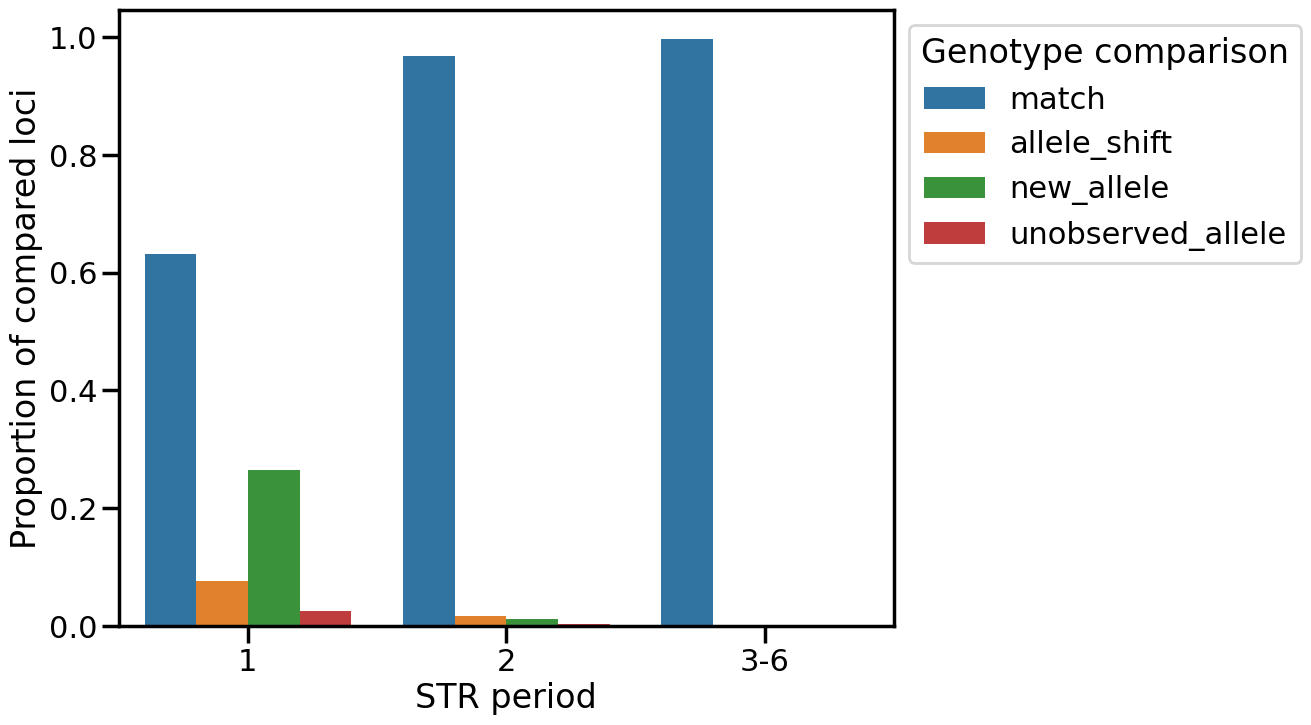

In [195]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    data = df_plot,
    x="period",
    y="proportion",
    hue="genotype_match"
)

_ = ax.get_legend().set(
    bbox_to_anchor=(1, 1),
    title="Genotype comparison"
)

_ = ax.set(
    xlabel="STR period",
    ylabel="Proportion of compared loci"
)

In [203]:
# print(df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").shape)
p1 = df_comp.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=False)

# print(df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10").shape)
p2 = df_comp.query(
    "period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=False)

# print(df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_01_0 >= 5").shape)
p3_6 = df_comp.query(
    "period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_01_0 >= 5"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=False)

df_plot = pd.concat([
    pd.DataFrame(p1).reset_index().assign(period = "1"), 
    pd.DataFrame(p2).reset_index().assign(period = "2"), 
    pd.DataFrame(p3_6).reset_index().assign(period = "3-6")
])

genotype_match = []
for i, j in df_plot.iterrows():
    if j["match"]:
        genotype_match.append("match")
        continue    
    elif j["unobserved_allele"]:
        genotype_match.append("unobserved_allele")
        continue
    elif j["new_allele"]:
        genotype_match.append("new_allele")
        continue
    genotype_match.append("allele_shift")
genotype_match = pd.Categorical(genotype_match, categories=["match", "allele_shift", "new_allele", "unobserved_allele"], ordered=True)
df_plot["genotype_match"] = genotype_match
df_plot = df_plot.drop(["match", "new_allele", "unobserved_allele"], axis=1)

print(df_plot[["period", "count"]].groupby("period").agg("sum"))

df_plot

         count
period        
1       175094
2         9393
3-6     466148


,count,period,genotype_match
0,110607,1,match
1,46443,1,new_allele
2,13507,1,allele_shift
3,4537,1,unobserved_allele
0,9093,2,match
1,163,2,allele_shift
2,111,2,new_allele
3,26,2,unobserved_allele
0,461874,3-6,match
1,2991,3-6,allele_shift


In [263]:
df_muts = pd.concat([
    # df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"),
    # df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"),
    df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_01_0 >= 5 and not match"),
]).reset_index(drop=True)

df_muts = df_muts.drop(["copy_number_LMO", "genotype_LMO"], axis=1).merge(
    df_LMO_filt[["str_id", "copy_number", "genotype"]].rename(columns={"copy_number": "copy_number_LMO", "genotype": "genotype_LMO"}),
    on="str_id"
)[['str_id', 'frequencies_LMO', 'depth_LMO', 'depth_norm_LMO', 'copy_number_LMO', 'genotype_LMO',
       'copy_number_01_0', 'frequencies_01_0', 'genotype_01_0', 'depth_01_0',
       'depth_norm_01_0', 'period', 'unit', 'match', 'new_allele',
       'unobserved_allele']]

print(df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_01_0 >= 5").shape)
print(df_muts.shape)
print(df_muts.query("unobserved_allele").shape)
df_muts.sample(20, random_state=42)

(466148, 17)
(4274, 16)
(250, 16)


,str_id,frequencies_LMO,depth_LMO,depth_norm_LMO,copy_number_LMO,genotype_LMO,copy_number_01_0,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,period,unit,match,new_allele,unobserved_allele
3845,chr9_74927532,"{7: 24, 8: 18}",42,21.00,2,"[7, 8]",4,"{7: 15, 8: 7}","[7, 7, 7, 8]",22,5.500,4,GCAA,False,False,False
3081,chr6_56087061,"{8: 12, 9: 15}",27,13.50,2,"[8, 9]",4,"{8: 5, 9: 15}","[8, 9, 9, 9]",20,5.000,5,TTTTG,False,False,False
2574,chr4_138810998,"{4: 3, 5: 49}",52,26.00,2,"[5, 5]",4,"{4: 5, 5: 34}","[4, 5, 5, 5]",39,9.750,4,TTTG,False,True,False
4160,chrX_92515059,"{2: 17, 3: 34}",51,25.50,2,"[2, 3]",4,"{2: 6, 3: 15}","[2, 3, 3, 3]",21,5.250,5,AAAAG,False,False,False
2932,chr5_178157926,"{10: 1, 11: 16, 12: 1, 13: 11}",29,14.50,2,"[11, 13]",4,"{10: 1, 11: 16, 13: 8}","[11, 11, 11, 13]",25,6.250,4,ATTT,False,False,False
2144,chr3_87257942,"{11: 12, 12: 13}",25,12.50,2,"[11, 12]",4,"{10: 1, 11: 10, 12: 20}","[11, 12, 12, 12]",31,7.750,3,AAT,False,False,False
1580,chr18_78638565,"{2: 3, 3: 12}",15,7.50,2,"[3, 3]",4,"{2: 8, 3: 16}","[2, 3, 3, 3]",24,6.000,5,CACAC,False,True,False
2498,chr4_87899410,"{6: 15, 7: 17}",32,16.00,2,"[6, 7]",4,"{6: 22, 7: 9}","[6, 6, 6, 7]",31,7.750,4,ATAA,False,False,False
3701,chr8_56675266,"{7: 13, 8: 41}",54,13.50,4,"[7, 8, 8, 8]",8,"{7: 20, 8: 31}","[7, 7, 7, 8, 8, 8, 8, 8]",51,6.375,5,AAATA,False,False,False
1620,chr19_14065838,"{4: 1, 5: 16, 6: 21}",38,19.00,2,"[5, 6]",4,"{5: 14, 6: 31}","[5, 6, 6, 6]",45,11.250,3,AAG,False,False,False


In [204]:
print(df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"
).shape)
df_comp.query(
    df_comp.query("period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"),
).head(10)

(721, 17)


,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_01_0,frequencies_01_0,genotype_01_0,depth_01_0,depth_norm_01_0,period,unit,match,new_allele,unobserved_allele
1077,chr1_3748139,2,"{5: 3, 6: 37}",40,20.0,"[6, 6, 6, 6]",4,4,"{5: 13, 6: 30}","[5, 6, 6, 6]",43,10.75,2,AC,False,True,False
1488,chr1_4744625,2,"{8: 1, 10: 22, 11: 8, 12: 1}",32,16.0,"[10, 10, 11, 11]",4,4,"{8: 2, 10: 28, 11: 16, 12: 1}","[10, 10, 10, 11]",47,11.75,2,CA,False,False,False
4196,chr1_9226652,2,"{3: 15, 5: 19}",34,17.0,"[3, 3, 5, 5]",4,4,"{3: 27, 5: 16}","[3, 3, 3, 5]",43,10.75,4,AAAT,False,False,False
4265,chr1_9350101,2,"{7: 6, 8: 40}",46,23.0,"[8, 8, 8, 8]",4,4,"{6: 2, 7: 12, 8: 28}","[7, 8, 8, 8]",42,10.50,2,AC,False,True,False
4406,chr1_9543131,2,"{6: 32, 7: 18}",50,25.0,"[6, 6, 7, 7]",4,4,"{6: 28, 7: 15}","[6, 6, 6, 7]",43,10.75,4,TTTA,False,False,False
4566,chr1_9708172,2,"{8: 21, 9: 18}",39,19.5,"[8, 8, 9, 9]",4,4,"{8: 12, 9: 30}","[8, 9, 9, 9]",42,10.50,4,TTTG,False,False,False
6147,chr1_11648972,2,"{4: 36, 5: 13}",49,24.5,"[4, 4, 5, 5]",4,4,"{4: 35, 5: 11}","[4, 4, 4, 5]",46,11.50,5,CAGCC,False,False,False
7075,chr1_13368089,2,"{4: 37, 5: 15}",52,26.0,"[4, 4, 5, 5]",4,4,"{4: 41, 5: 1}","[4, 4, 4, 4]",42,10.50,4,AAAC,False,True,False
8510,chr1_15686468,2,"{7: 30, 8: 6}",36,18.0,"[7, 7, 7, 7]",4,4,"{7: 30, 8: 15}","[7, 7, 7, 8]",45,11.25,3,TTG,False,True,False
9766,chr1_17740262,2,{10: 22},22,11.0,"[10, 10, 10, 10]",4,4,"{9: 5, 10: 34, 11: 1}","[9, 10, 10, 10]",40,10.00,2,TC,False,True,True


In [ ]:
print(df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"
).shape)
df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_01_0 >= 10 and not match"
).head(10)